In [1]:
!pip install ppscore

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 60.1 MB/s eta 0:00:0000:010:01
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13165 sha256=4f916a7832cff77f9b8c75bc209192b87bfe8b5dea89aff06df09b93cf9609ad
  Stored in directory: /root/.cache/pip/wheels/42/87/10/00056aa2d2624f1b9374db6a0d5245da9a3d87bdc9247c1a56
Successfully built ppscore
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask

In [2]:
# Libraries
import ppscore as pps
import math, re, os, gc
import joblib
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets
import json
import shutil
import zipfile
import re
import tensorflow as tf

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from joblib import Parallel, delayed
from scipy import sparse

# Data
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
!pip install --upgrade kaggle

In [5]:
# Kaggle API Using Secrets

from kaggle_secrets import UserSecretsClient

# Brought key info
user_secrets = UserSecretsClient()
kaggle_key = user_secrets.get_secret("jiyoungroh")

# Setting
os.environ['KAGGLE_KEY'] = kaggle_key
os.environ['KAGGLE_USERNAME'] = "jiyoungroh"

In [6]:
!kaggle competitions download -c playground-series-s4e8

 89%|██████████████████████████████████▌    | 73.0M/82.3M [00:00<00:00, 105MB/s]
100%|███████████████████████████████████████| 82.3M/82.3M [00:00<00:00, 102MB/s]


In [7]:
# Unzip
with zipfile.ZipFile('/kaggle/working/playground-series-s4e8.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

# Loading Data
train_data = pd.read_csv('/kaggle/working/train.csv')
test_data = pd.read_csv('/kaggle/working/test.csv')
sample_submission = pd.read_csv('/kaggle/working/sample_submission.csv')

del sample_submission
gc.collect()

0

In [8]:
pd.set_option('display.max_columns', None)
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [9]:
pp_scores = []

for col in train_data.columns[1:]:
    pp_score = pps.score(train_data, col, "class")["ppscore"]
    pp_scores.append(pp_score)

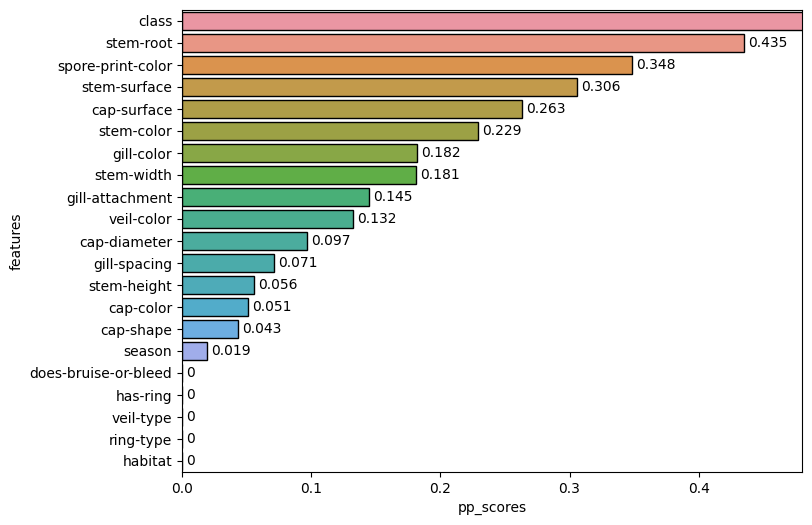

In [10]:
data = pd.DataFrame({
    "features": list(train_data.columns[1:]),
    "pp_scores": np.round(pp_scores, 3)
}).sort_values("pp_scores", ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(data, x = "pp_scores", y = "features", edgecolor = "#000000")

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10)
    
plt.xlim(0, 0.48)
plt.show()

In [11]:
def print_poisonous_percentage(col, unique_val):
    n_rows = train_data[train_data[col] == unique_val].shape[0]
    print(f"Rows with value of {unique_val}:", n_rows)
    print("Edible %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[0], 3))
    print("Posionous %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[1], 3))
    print()
    return n_rows

def print_vals(col, vals):
    n_rows = 0
    for val in vals:
        n_rows += print_poisonous_percentage(col = col, unique_val = val)
    print("Total rows", n_rows)

In [12]:
print_vals(col = "stem-root", vals = ["r", "c", "f"])

Rows with value of r: 47803
Edible %: 0.995
Posionous %: 0.005

Rows with value of c: 28592
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 597
Edible %: 0.988
Posionous %: 0.012

Total rows 76992


In [13]:
print_vals(col = "spore-print-color", vals = ["n", "r", "u", "g"])

Rows with value of n: 22646
Edible %: 0.997
Posionous %: 0.003

Rows with value of r: 7975
Edible %: 0.997
Posionous %: 0.003

Rows with value of u: 7256
Edible %: 0.997
Posionous %: 0.003

Rows with value of g: 3492
Edible %: 0.972
Posionous %: 0.028

Total rows 41369


In [14]:
print_vals(col = "stem-surface", vals = ["g", "h", "f"])

Rows with value of g: 78080
Edible %: 0.996
Posionous %: 0.004

Rows with value of h: 28283
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 512
Edible %: 0.99
Posionous %: 0.01

Total rows 106875


In [15]:
print_vals(col = "stem-color", vals = ["b", "f"])

Rows with value of b: 7365
Edible %: 0.994
Posionous %: 0.006

Rows with value of f: 573
Edible %: 0.981
Posionous %: 0.019

Total rows 7938


In [16]:
# Missing values ratio
missing_values_ratio = train_data.isnull().mean() * 100
missing_values_ratio = missing_values_ratio.sort_values(ascending=False)

print(missing_values_ratio)

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
class                    0.000000
id                       0.000000
stem-width               0.000000
stem-height              0.000000
season                   0.000000
dtype: float64


# 1. Missing Value Preprocessing

missing values between 60% and 80%: Change to 'Unknown'

Under 50%: Exchange to mean or median

In [17]:
# Used PPS, numeric cor, categoric cor(chi-square, cramer's V, Theil's U)
selected_numeric = ['stem-width']
selected_categoric_train = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 
                    'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
selected_categoric_test = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 
                    'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']

## 1-1. Categoric Data Preprocessing

In [18]:
columns_to_fill = ['spore-print-color', 'stem-root', 'veil-color', 'stem-surface']

# fill to 'Unknown'
train_data[columns_to_fill] = train_data[columns_to_fill].fillna('Unknown')
test_data[columns_to_fill] = test_data[columns_to_fill].fillna('Unknown')

print(train_data[columns_to_fill].isnull().sum()) 

spore-print-color    0
stem-root            0
veil-color           0
stem-surface         0
dtype: int64


In [19]:
columns_to_fill_with_mode = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 
                             'gill-spacing', 'gill-color', 'stem-color', 'ring-type', 
                             'habitat', 'season']

# Inplace missing values to mode
for column in columns_to_fill_with_mode:
    mode_value = train_data[column].mode()[0]  # calculate most common value
    train_data[column].fillna(mode_value, inplace=True)  # Inplace
    
for column in columns_to_fill_with_mode:
    mode_value = test_data[column].mode()[0]  # calculate most common value
    test_data[column].fillna(mode_value, inplace=True)  # Inplace

print(train_data[columns_to_fill_with_mode].isnull().sum()) 


cap-shape          0
cap-surface        0
cap-color          0
gill-attachment    0
gill-spacing       0
gill-color         0
stem-color         0
ring-type          0
habitat            0
season             0
dtype: int64


In [20]:
# Missing values ratio
missing_values_ratio = train_data.isnull().mean() * 100
missing_values_ratio = missing_values_ratio.sort_values(ascending=False)

print(missing_values_ratio)

veil-type               94.884350
has-ring                 0.000770
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
class                    0.000000
id                       0.000000
cap-color                0.000000
cap-surface              0.000000
cap-shape                0.000000
gill-attachment          0.000000
stem-height              0.000000
stem-width               0.000000
gill-spacing             0.000000
gill-color               0.000000
stem-surface             0.000000
stem-root                0.000000
stem-color               0.000000
veil-color               0.000000
ring-type                0.000000
spore-print-color        0.000000
habitat                  0.000000
season                   0.000000
dtype: float64


# 2. Encoding

'class', 'stem-width', 'cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 
                    'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season'

In [21]:
# Unique Class Counts

unique_class_counts = train_data.nunique()

print(unique_class_counts)

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    39
stem-surface                 61
stem-color                   59
veil-type                    22
veil-color                   25
has-ring                     23
ring-type                    40
spore-print-color            33
habitat                      52
season                        4
dtype: int64


## 2-1. One Hot Encoding ( TOO MANY :( )

In [22]:
categorical_columns_train = [col for col in selected_categoric_train if col != 'class']
categorical_columns_test = selected_categoric_test

# OneHotEncoder Setting
encoder = OneHotEncoder(sparse=True, dtype=int, handle_unknown='ignore')

# Train data one hot encoding
encoded_train = encoder.fit_transform(train_data[categorical_columns_train])

# Test data one hot encoding
encoded_test = encoder.transform(test_data[categorical_columns_test])

# To preserce memory... ... ...
encoded_train_df = pd.DataFrame.sparse.from_spmatrix(encoded_train, columns=encoder.get_feature_names_out())
encoded_test_df = pd.DataFrame.sparse.from_spmatrix(encoded_test, columns=encoder.get_feature_names_out())

# concat with origin data
train_data = pd.concat([train_data.drop(categorical_columns_train, axis=1), encoded_train_df], axis=1)
test_data = pd.concat([test_data.drop(categorical_columns_test, axis=1), encoded_test_df], axis=1)

print(f"Train data shape after encoding: {train_data.shape}")
print(f"Test data shape after encoding: {test_data.shape}")

Train data shape after encoding: (3116945, 745)
Test data shape after encoding: (2077964, 744)


In [23]:
# reset one hot encoding
encoder = OneHotEncoder(sparse=True, dtype=int)

# one hot encoding on class
encoded_class = encoder.fit_transform(train_data[['class']])

encoded_class_df = pd.DataFrame.sparse.from_spmatrix(encoded_class, columns=encoder.get_feature_names_out(['class']))

# concat
train_data = train_data.drop('class', axis=1)  # 기존 class 열 제거
train_data = pd.concat([train_data, encoded_class_df], axis=1)

In [24]:
train_data.head()

,id,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_0.82,cap-shape_1.66,cap-shape_10.13,cap-shape_10.46,cap-shape_11.12,cap-shape_12.62,cap-shape_17.44,cap-shape_19.04,cap-shape_19.06,cap-shape_19.29,cap-shape_2.63,cap-shape_2.77,cap-shape_2.82,cap-shape_2.85,cap-shape_2.94,cap-shape_20.25,cap-shape_21.56,cap-shape_24.16,cap-shape_3 x,cap-shape_3.04,cap-shape_3.25,cap-shape_3.37,cap-shape_3.52,cap-shape_3.55,cap-shape_3.6,cap-shape_3.91,cap-shape_4.22,cap-shape_4.3,cap-shape_4.33,cap-shape_4.97,cap-shape_49.21,cap-shape_5 f,cap-shape_5.15,cap-shape_54.78,cap-shape_6 x,cap-shape_6.21,cap-shape_6.44,cap-shape_6.53,cap-shape_7 x,cap-shape_7.21,cap-shape_7.41,cap-shape_7.43,cap-shape_7.6,cap-shape_8,cap-shape_8.29,cap-shape_8.3,cap-shape_9.13,cap-shape_a,cap-shape_b,cap-shape_b f,cap-shape_c,cap-shape_d,cap-shape_e,cap-shape_f,cap-shape_g,cap-shape_h,cap-shape_i,cap-shape_is p,cap-shape_is s,cap-shape_k,cap-shape_l,cap-shape_m,cap-shape_n,cap-shape_o,cap-shape_p,cap-shape_r,cap-shape_ring-type,cap-shape_s,cap-shape_t,cap-shape_u,cap-shape_w,cap-shape_x,cap-shape_y,cap-shape_z,cap-surface_0.85,cap-surface_0.87,cap-surface_0.88,cap-surface_1.08,cap-surface_1.14,cap-surface_1.42,cap-surface_1.43,cap-surface_10.1,cap-surface_10.34,cap-surface_10.83,cap-surface_11.78,cap-surface_12.2,cap-surface_12.79,cap-surface_14.04,cap-surface_15.94,cap-surface_16.39,cap-surface_2.11,cap-surface_2.51,cap-surface_2.7,cap-surface_2.79,cap-surface_2.81,cap-surface_2.92,cap-surface_23.18,cap-surface_24.38,cap-surface_3.06,cap-surface_3.33,cap-surface_3.64,cap-surface_4.21,cap-surface_4.66,cap-surface_4.93,cap-surface_41.91,cap-surface_5.07,cap-surface_5.73,cap-surface_6.45,cap-surface_6.49,cap-surface_6.57,cap-surface_7.14,cap-surface_7.99,cap-surface_8.01,cap-surface_8.1,cap-surface_8.96,cap-surface_9.22,cap-surface_a,cap-surface_b,cap-surface_c,cap-surface_cap-diameter,cap-surface_class,cap-surface_d,cap-surface_does None,cap-surface_does h,cap-surface_does l,cap-surface_does t,cap-surface_does-bruise-or-bleed,cap-surface_e,cap-surface_f,cap-surface_g,cap-surface_h,cap-surface_has h,cap-surface_has-ring,cap-surface_i,cap-surface_is None,cap-surface_is h,cap-surface_is k,cap-surface_is y,cap-surface_k,cap-surface_l,cap-surface_m,cap-surface_n,cap-surface_o,cap-surface_p,cap-surface_r,cap-surface_ring-type,cap-surface_s,cap-surface_season,cap-surface_spore-color,cap-surface_spore-print-color,cap-surface_t,cap-surface_u,cap-surface_veil-color,cap-surface_w,cap-surface_x,cap-surface_y,cap-surface_z,cap-color_1.51,cap-color_10.1,cap-color_10.56,cap-color_11.13,cap-color_11.92,cap-color_12.89,cap-color_13,cap-color_17.19,cap-color_17.93,cap-color_17.94,cap-color_2.05,cap-color_2.57,cap-color_2.7,cap-color_2.82,cap-color_2.9,cap-color_20,cap-color_20.02,cap-color_20.62,cap-color_21.53,cap-color_22.38,cap-color_24.75,cap-color_25.98,cap-color_26.89,cap-color_3.08,cap-color_3.11,cap-color_3.34,cap-color_3.57,cap-color_3.95,cap-color_4. n,cap-color_4.24,cap-color_4.89,cap-color_4.98,cap-color_5.25,cap-color_5.41,cap-color_5.91,cap-color_6.2,cap-color_6.36,cap-color_6.41,cap-color_6.59,cap-color_6.76,cap-color_6.9,cap-color_7,cap-color_7.15,cap-color_7.72,cap-color_8.57,cap-color_8.67,cap-color_8.83,cap-color_9.02,cap-color_a,cap-color_b,cap-color_c,cap-color_class,cap-color_d,cap-color_does n,cap-color_does-bruise-or-bleed,cap-color_e,cap-color_f,cap-color_g,cap-color_h,cap-color_i,cap-color_k,cap-color_l,cap-color_m,cap-color_n,cap-color_o,cap-color_p,cap-color_r,cap-color_ring-type,cap-color_s,cap-color_season,cap-color_stem-surface,cap-color_t,cap-color_u,cap-color_veil-color,cap-color_w,cap-color_x,cap-color_y,cap-color_z,gill-attachment_0.92,gill-attachment_1,gill-attachment_1.32,gill-attachment_1.37,gill-attachment_1.48,gill-attachment_1.51,gill-attachment_10.23,gill-attachment_10.85,gill-attachment_11.26,gill-attachment_11.62,gill-attachment_13.15,gill-attachment_13.94,gill-attachment_15.49,gill-attachment_16.27,gil

In [25]:
num_columns = len(train_data.columns)

print(f"Number of Column: {num_columns}")

Number of Column: 746


# 3. Feature Engineering

## 3-1. Simple model for feature selection

In [26]:
columns_to_exclude = ['cap-diameter', 'does-bruise-or-bleed', 'stem-height', 'veil-type', 'has-ring']

# train_data에서 해당 열을 제외
train_data = train_data.drop(columns=columns_to_exclude)
test_data = test_data.drop(columns=columns_to_exclude)

In [27]:
# Data Split ('Class_e' is target class)
X = train_data.drop(['class_e', 'class_p'], axis=1).copy() 
y = train_data['class_e'].copy()  # target label

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost
model = XGBClassifier(tree_method='gpu_hist', random_state=42)
model.fit(X_train, y_train)

# prediction and accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# feature importance
importances = model.feature_importances_
feature_names = X.columns

# transfrom feature importance to dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 상위 10개의 중요도 표시
print(feature_importance_df.head(10))

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type='gain')  # 중요도가 높은 상위 10개 피처만 시각화
plt.title('Feature Importance (XGBoost)')
plt.show()

joblib.dump(model, 'xg_boost_model.pkl')
print("Model saved as 'xg_boost_model.pkl'")

feature_importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved as 'feature_importance.csv'")

In [28]:
# 저장된 XGBoost 모델 불러오기
loaded_xgb_model = joblib.load('/kaggle/input/lightgbm_model/scikitlearn/default/1/lightgbm_model.pkl')
print("Light XGB model loaded succefully")

# 피처 중요도 데이터 불러오기
feature_importance_df = pd.read_csv('/kaggle/input/feature-importance/feature_importance.csv')
print("feature importance csv file loaded succefully")

Light XGB model loaded succefully
feature importance csv file loaded succefully


In [29]:
# Setting threshold
threshold = 0.001
  
# Select features having importance over threshold rate
selected_features_df = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# result
selected_features_df

,Feature,Importance
0,ring-type_z,0.046111
1,gill-attachment_f,0.044447
2,gill-attachment_p,0.032357
3,cap-shape_c,0.030581
4,stem-surface_s,0.029518
...,...,...
95,cap-color_o,0.001372
96,cap-color_u,0.001360
97,veil-color_n,0.001278
98,habitat_l,0.001229


# selected_features_df
selected_features_df.to_csv('selected_features.csv', index=False)
print("Selected features saved as 'selected_features.csv'")

In [30]:
selected_features_df = pd.read_csv('/kaggle/input/selected-features/selected_features (1).csv')

In [31]:
selected_features = selected_features_df['Feature'].tolist()

In [32]:
# 원래의 train_data 및 test_data를 복사하여 새로운 데이터프레임 생성
original_train_data = train_data.copy()
original_test_data = test_data.copy()

# 피처 중요도에 따라 선택된 피처들 목록
selected_features = selected_features_df['Feature'].tolist()

# train_data에서 선택된 피처들과 class_e, class_p를 포함하여 필터링
selected_features_with_class = selected_features + ['class_e', 'class_p']
train_data = original_train_data[selected_features_with_class]

# test_data에서는 선택된 피처들만 포함하여 필터링 (class_e, class_p 제외)
test_data = original_test_data[selected_features]

In [33]:
test_data.shape[1]

100

In [34]:
train_data.head()

,ring-type_z,gill-attachment_f,gill-attachment_p,cap-shape_c,stem-surface_s,cap-surface_l,stem-root_r,gill-spacing_d,stem-color_p,stem-surface_g,cap-surface_w,cap-color_r,stem-root_s,ring-type_r,stem-root_b,spore-print-color_w,cap-shape_b,veil-color_u,stem-root_c,gill-attachment_e,cap-surface_k,stem-color_k,cap-surface_g,ring-type_f,cap-color_e,gill-spacing_c,veil-color_w,gill-color_f,cap-surface_y,habitat_m,cap-surface_d,cap-surface_e,gill-color_g,gill-color_p,gill-color_k,habitat_d,stem-color_w,cap-color_b,stem-surface_k,ring-type_g,cap-surface_s,gill-color_y,habitat_g,stem-surface_Unknown,stem-surface_t,spore-print-color_k,habitat_h,stem-color_g,gill-color_w,gill-attachment_d,cap-surface_i,stem-surface_y,veil-color_Unknown,stem-surface_h,stem-color_y,stem-color_l,cap-shape_s,gill-attachment_x,stem-width,gill-color_o,stem-color_b,cap-color_y,stem-color_o,gill-color_n,gill-color_r,gill-attachment_s,stem-color_e,gill-color_e,gill-attachment_a,stem-color_r,cap-surface_t,cap-color_w,spore-print-color_Unknown,stem-root_Unknown,stem-color_n,season_w,stem-surface_i,cap-surface_h,ring-type_e,cap-color_l,ring-type_l,cap-shape_x,cap-color_n,ring-type_m,stem-color_u,season_s,spore-print-color_n,cap-shape_o,gill-spacing_f,cap-shape_f,habitat_p,cap-color_k,cap-color_p,habitat_w,spore-print-color_g,cap-color_o,cap-color_u,veil-color_n,habitat_l,cap-color_g,class_e,class_p
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,15.39,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,6.48,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,9.93,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6.53,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,8.36,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [35]:
test_data.head()

,ring-type_z,gill-attachment_f,gill-attachment_p,cap-shape_c,stem-surface_s,cap-surface_l,stem-root_r,gill-spacing_d,stem-color_p,stem-surface_g,cap-surface_w,cap-color_r,stem-root_s,ring-type_r,stem-root_b,spore-print-color_w,cap-shape_b,veil-color_u,stem-root_c,gill-attachment_e,cap-surface_k,stem-color_k,cap-surface_g,ring-type_f,cap-color_e,gill-spacing_c,veil-color_w,gill-color_f,cap-surface_y,habitat_m,cap-surface_d,cap-surface_e,gill-color_g,gill-color_p,gill-color_k,habitat_d,stem-color_w,cap-color_b,stem-surface_k,ring-type_g,cap-surface_s,gill-color_y,habitat_g,stem-surface_Unknown,stem-surface_t,spore-print-color_k,habitat_h,stem-color_g,gill-color_w,gill-attachment_d,cap-surface_i,stem-surface_y,veil-color_Unknown,stem-surface_h,stem-color_y,stem-color_l,cap-shape_s,gill-attachment_x,stem-width,gill-color_o,stem-color_b,cap-color_y,stem-color_o,gill-color_n,gill-color_r,gill-attachment_s,stem-color_e,gill-color_e,gill-attachment_a,stem-color_r,cap-surface_t,cap-color_w,spore-print-color_Unknown,stem-root_Unknown,stem-color_n,season_w,stem-surface_i,cap-surface_h,ring-type_e,cap-color_l,ring-type_l,cap-shape_x,cap-color_n,ring-type_m,stem-color_u,season_s,spore-print-color_n,cap-shape_o,gill-spacing_f,cap-shape_f,habitat_p,cap-color_k,cap-color_p,habitat_w,spore-print-color_g,cap-color_o,cap-color_u,veil-color_n,habitat_l,cap-color_g
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,17.12,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10.75,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.14,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.51,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,13.70,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
import gc

preserve_dfs = ['train_data', 'test_data']

# select only dataframes
dataframes = {key: value for key, value in globals().items() if isinstance(value, pd.DataFrame)}

# check the dataframes and delete
for df_name in dataframes:
    if df_name not in preserve_dfs:
        print(f"Deleting DataFrame: {df_name}")
        del globals()[df_name]

# run garbage collection
gc.collect()

# check the remaning datatframes
print(f"Remaining DataFrames: train_data (행: {train_data.shape[0]}, 열: {train_data.shape[1]}), test_data (행: {test_data.shape[0]}, 열: {test_data.shape[1]})")


Deleting DataFrame: _
Deleting DataFrame: __
Deleting DataFrame: _8
Deleting DataFrame: data
Deleting DataFrame: encoded_train_df
Deleting DataFrame: encoded_test_df
Deleting DataFrame: encoded_class_df
Deleting DataFrame: _24
Deleting DataFrame: X
Deleting DataFrame: X_train
Deleting DataFrame: X_test
Deleting DataFrame: feature_importance_df
Deleting DataFrame: selected_features_df
Deleting DataFrame: _29
Deleting DataFrame: original_train_data
Deleting DataFrame: original_test_data
Deleting DataFrame: _34
Deleting DataFrame: _35
Remaining DataFrames: train_data (행: 3116945, 열: 102), test_data (행: 2077964, 열: 100)


If the result is not great, then after that, I will do the PCA and correlation check and set feature selection again

# 4. Simple Model Check

## 4-1. Random Forest and Logistic Regression Compare

In [37]:
X = train_data.drop(['class_e', 'class_p'], axis=1)  # Remove 'class_e' and 'class_p', because they are target class
y = train_data['class_e']  # target class

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model train
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Random Forest prediction and accuracy
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Logistic Regression train
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Logistic Regression prediction and accuracy
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# cross val score
cv = 5  # setting the number

# Random Forest cross validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores)}")

# Logistic Regression cross validation
lr_cv_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(lr_cv_scores)}")

# 1. 모델 저장
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')

print("Models saved as 'random_forest_mmodel.pkl' and 'logistic_regression_model.pkl'")

# 2. 교차 검증 결과 저장
cv_results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Test Accuracy': [rf_accuracy, lr_accuracy],
    'Cross-Validation Accuracy': [np.mean(rf_cv_scores), np.mean(lr_cv_scores)]
})

cv_results.to_csv('cv_results.csv', index=False)
print("RF_LR_Cross-validation results saved as 'cv_results.csv'")

In [38]:
# Loaded rf, lr model
loaded_random_forest_model = joblib.load('/kaggle/input/random_forest_mushroom/scikitlearn/default/1/random_forest_model.pkl')
print("Random Forest loaded succefully")

loaded_logistic_regression_model = joblib.load('/kaggle/input/logistic_regression_model/scikitlearn/default/1/logistic_regression_model.pkl')
print("Logistic Regression loaded succefully")

# cv_results
rf_lr_cv_results = pd.read_csv('/kaggle/input/rf-lg-cv-results/cv_results.csv')
print("cv results csv file loaded succefully")

Random Forest loaded succefully
Logistic Regression loaded succefully
cv results csv file loaded succefully


!pip install lightgbm --install-option=--gpu

import lightgbm as lgb

# LightGBM 모델 설정 및 학습
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100, boosting_type='gbdt', device='gpu')
lgb_model.fit(X_train, y_train)

# LightGBM 예측 및 성능 평가
y_pred_lgb = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy: {lgb_accuracy}")

# 교차 검증 설정
cv = 5  # 교차 검증 횟수 설정

# LightGBM 교차 검증
lgb_cv_scores = cross_val_score(lgb_model, X, y, cv=cv, scoring='accuracy')
print(f"LightGBM Cross-Validation Accuracy: {np.mean(lgb_cv_scores)}")

# 1. LightGBM 모델 저장
joblib.dump(lgb_model, 'lightgbm_model.pkl')
print("LightGBM model saved as 'lightgbm_model.pkl'")

# 2. 교차 검증 결과 저장
cv_results_lgb = pd.DataFrame({
    'Model': ['LightGBM'],
    'Test Accuracy': [lgb_accuracy],
    'Cross-Validation Accuracy': [np.mean(lgb_cv_scores)]
})

cv_results_lgb.to_csv('lgb_cv_results.csv', index=False)
print("LightGBM cross-validation results saved as 'lgb_cv_results.csv'")

In [39]:
loaded_light_GBM_model = joblib.load('/kaggle/input/lightgbm_model/scikitlearn/default/1/lightgbm_model.pkl')
print("Light GBM model loaded succefully")

# cv_results
lgb_cv_results = pd.read_csv('/kaggle/input/gb-cv-results/lgb_cv_results.csv')
print("lgb cv results csv file loaded succefully")

# 데이터 확인
print("LightGBM Cross-Validation Results:")
print(lgb_cv_results.head())
print("\nRandom Forest and Logistic Regression Cross-Validation Results:")
print(rf_lr_cv_results.head())

Light GBM model loaded succefully
lgb cv results csv file loaded succefully
LightGBM Cross-Validation Results:
      Model  Test Accuracy  Cross-Validation Accuracy
0  LightGBM       0.986673                   0.987188

Random Forest and Logistic Regression Cross-Validation Results:
                 Model  Test Accuracy  Cross-Validation Accuracy
0        Random Forest       0.989103                   0.989252
1  Logistic Regression       0.837528                   0.837518


In [40]:
print("LightGBM Cross-Validation Results Columns:")
print(lgb_cv_results.columns)
print("\nRandom Forest and Logistic Regression Cross-Validation Results Columns:")
print(rf_lr_cv_results.columns)

LightGBM Cross-Validation Results Columns:
Index(['Model', 'Test Accuracy', 'Cross-Validation Accuracy'], dtype='object')

Random Forest and Logistic Regression Cross-Validation Results Columns:
Index(['Model', 'Test Accuracy', 'Cross-Validation Accuracy'], dtype='object')


In [41]:
# LightGBM의 평균 정확도 계산
lgb_mean_accuracy = lgb_cv_results['Cross-Validation Accuracy'].mean()

# Random Forest와 Logistic Regression의 평균 정확도 계산
rf_lr_mean_accuracy = rf_lr_cv_results['Cross-Validation Accuracy'].mean()

# 성능 비교 출력
print(f"LightGBM 평균 정확도: {lgb_mean_accuracy:.4f}")
print(f"Random Forest/Logistic Regression 평균 정확도: {rf_lr_mean_accuracy:.4f}")

if lgb_mean_accuracy > rf_lr_mean_accuracy:
    print("LightGBM 모델이 더 나은 성능을 보입니다.")
else:
    print("Random Forest/Logistic Regression 모델이 더 나은 성능을 보입니다.")

LightGBM 평균 정확도: 0.9872
Random Forest/Logistic Regression 평균 정확도: 0.9134
LightGBM 모델이 더 나은 성능을 보입니다.


In [42]:
model_path = '/kaggle/input/lightgbm_model/scikitlearn/default/1/lightgbm_model.pkl'
lgb_model = joblib.load(model_path)
print("LightGBM model loaded successfully.")

LightGBM model loaded successfully.


In [43]:
# 예측 수행
y_pred_test = lgb_model.predict(test_data)

# 1을 'e'로, 0을 'p'로 변환
class_mapping = {1: 'e', 0: 'p'}
y_pred_class = [class_mapping[pred] for pred in y_pred_test]

# 예측 결과 확인
print("Test data predictions (converted to 'e' and 'p'):")
print(y_pred_class[:5])

Test data predictions (converted to 'e' and 'p'):
['e', 'p', 'p', 'p', 'e']


In [44]:
# 예측 결과를 CSV 파일로 저장 (선택 사항)
output_df = pd.DataFrame({
    'id': test_data.index,  # 고유 식별자가 있을 경우 사용, 없으면 `range(len(y_pred_class))` 사용
    'prediction': y_pred_class
})
output_df.to_csv('test_predictions_converted.csv', index=False)
print("Predictions saved to 'test_predictions_converted.csv'")

Predictions saved to 'test_predictions_converted.csv'


In [46]:
output_df.head()

,id,prediction
0,0,e
1,1,p
2,2,p
3,3,p
4,4,e


In [49]:
output_df.shape[0]

2077964